In [1]:
# Data Source:
# Amazon Customer Reviews Multiple datasets are available in the repository.
# The Electronics dataset is being used for this example.
# Amazon recently implemented a method 
# called item-to-item collaborative filtering, 
# which is designed for extending to huge amounts
# of data and producing exceptional suggestions in actual time.

In [2]:
# Description of the Dataset:
# UserId: Each user has a unique id 
# ProductId: Each product has a unique id 
# Rating: Each user's rating of the relevant product 
#Timestamp: The time the rating was made 
#(ignoring this attribute since it does not effect the model)

In [3]:
#Importing the needed libraries
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
#Reading the dataset
data1=pd.read_excel("C:\\Users\\kashi\\OneDrive\\Desktop\\dataset2.xlsx",names=['userId', 'productId','Rating','timestamp'])

In [5]:
#head of the dataset
data1.head()

,userId,productId,Rating,timestamp
0,A2CX7LUOHB2NDG,321732944,5,1341100800
1,A2NWSAGRHCP8N5,439886341,1,1367193600
2,A2WNBOD3WNDNKT,439886341,3,1374451200
3,A1GI0U4ZRJA8WN,439886341,1,1334707200
4,A1QGNMC6O1VW39,511189877,5,1397433600


In [6]:
#Finding the number of rows and columns in the dataset
data1.shape

(1048575, 4)

In [7]:
#Checking the datatypes of all attributes
data1.dtypes

userId       object
productId    object
Rating        int64
timestamp     int64
dtype: object

In [8]:
#more information regarding the dataset
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1048575 non-null  object
 1   productId  1048575 non-null  object
 2   Rating     1048575 non-null  int64 
 3   timestamp  1048575 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 32.0+ MB


<AxesSubplot:xlabel='Rating', ylabel='count'>

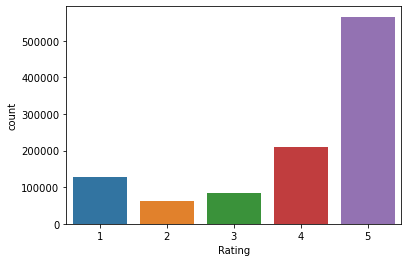

In [9]:
#Checking the frequency of each ratings
sns.countplot(data=data1, x='Rating')

In [10]:
#Checking the minimum and maximum rating in the dataset
print('Minimum rating is: %d' %(data1.Rating.min()))
print('Maximum rating is: %d' %(data1.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [11]:
#Checking the missing values(na)
data1.isna().sum()

userId       0
productId    0
Rating       0
timestamp    0
dtype: int64

In [12]:
print("Total no. of Ratings:",data1.shape[0])
print("Total no. of Users:",len(np.unique(data1.userId)))
#print("Total no. of Products:",len(np.unique(data1.productId)))

Total no. of Ratings: 1048575
Total no. of Users: 786329


In [13]:
#Dropping the timestamp attribute
data1.drop(['timestamp'], axis=1,inplace=True)

In [14]:
#finding the maximum ratings given by a user for a particular product
max_ratings=data1.groupby(['userId','productId'])['Rating'].max().sort_values(ascending=False)

In [15]:
max_ratings.head()

userId                 productId 
A00037441I8XOQJSUWCAG  B000I3C624    5
A2QZ36LCF7XX0C         B0000AZ67Y    5
A2QZ69NJD4CHVA         B0002KR74A    5
AFSMQCSZEU71O          B00004TWM6    5
A2QZ6S2PLAGED6         B0002BG2PO    5
Name: Rating, dtype: int64

In [16]:
min_ratings=data1.groupby(['userId','productId'])['Rating'].min().sort_values(ascending=False) 

In [17]:
min_ratings.head()

userId                 productId 
A00037441I8XOQJSUWCAG  B000I3C624    5
A2QZ36LCF7XX0C         B0000AZ67Y    5
A2QZ69NJD4CHVA         B0002KR74A    5
AFSMQCSZEU71O          B00004TWM6    5
A2QZ6S2PLAGED6         B0002BG2PO    5
Name: Rating, dtype: int64

In [18]:
#for consistency remove duplicates if there is any
data1.drop_duplicates(inplace=True)

In [19]:
#Analysis of the total number of product ratings contributed by a certain user 
no_of_rated_products_per_user = data1.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [20]:
no_of_rated_products_per_user.describe().astype(int).T

count    786329
mean          1
std           1
min           1
25%           1
50%           1
75%           1
max         412
Name: Rating, dtype: int32

<AxesSubplot:>

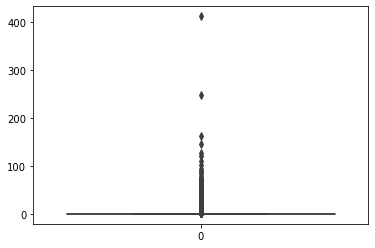

In [21]:
#Boxplot shows that most users rate only a handful of items,
#whereas a tiny minority rate a much larger number of objects (shown by outliers).
sns.boxplot(data=no_of_rated_products_per_user)

In [22]:
#Let's take a look at the quantiles to see where the bulk of the ratings fall.
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

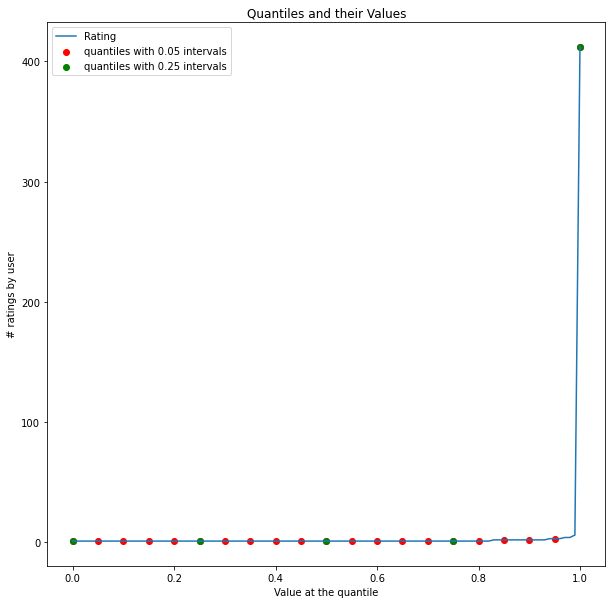

In [23]:
#Basically, the outliers that we observed 
#previously are represented here in the peak 
#of the distribution, as shown by the fact 
#that all of the ratings are grouped together at the very top of the quantile.
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='red', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='green', label = "quantiles with 0.25 intervals")
plt.ylabel('# ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [24]:
print('number of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )

number of rated product more than 50 per user : 38



In [25]:
# Obtaining the new dataframe that 
#includes people who have rated this post a total of fifty times or more
new_df=data1.groupby("userId").filter(lambda x:x['Rating'].count() >=50)

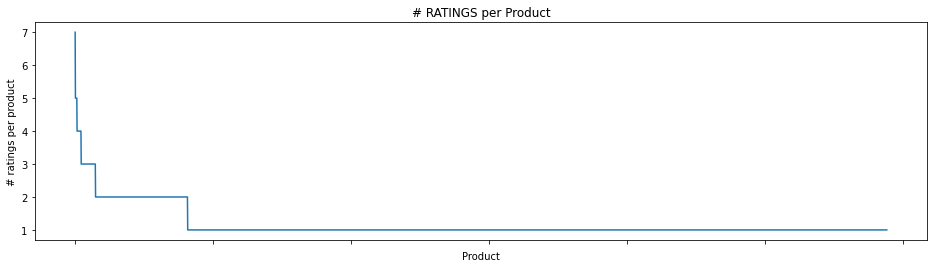

In [26]:
# The bulk of items have extremely few ratings,
# which contributes to the overall unbalanced rating system for products.
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=(16,4))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('# ratings per product')
ax.set_xticklabels([])

plt.show()

In [27]:
#Boxplot demonstrates that just a handful of our items have
#received a high number of ratings, while the vast majority have received relatively low ratings.
#sns.boxplot(data=no_of_ratings_per_product);

In [28]:
#First, let's take a look at the 
#quantile view to figure out where the majority of the ratings fall.
quantiles = no_of_ratings_per_product.quantile(np.arange(0,1.01,0.01), interpolation='higher')

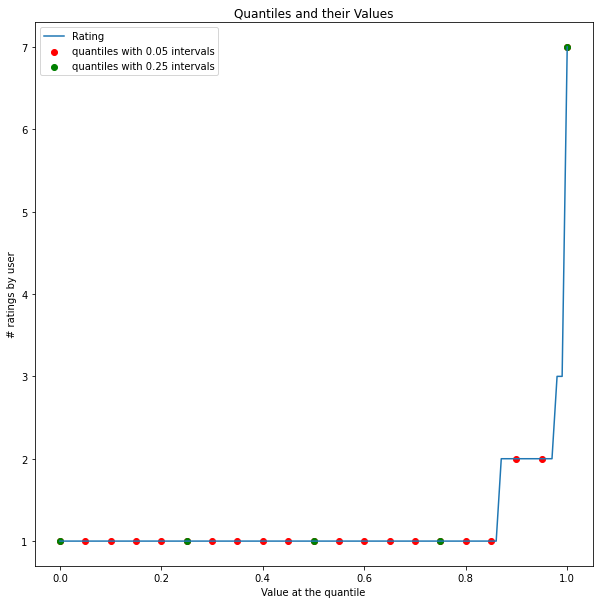

In [29]:
#This confirms our conclusion above in the boxplot, 
#where we can see that all of the ratings are grouped at the upper end of the quantile.
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='red', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='green', label = "quantiles with 0.25 intervals")
plt.ylabel('# ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [30]:
#Rating of the product, on average, based on feedback from consumers
new_df.groupby('productId')['Rating'].mean().head()

productId
1400532655    1.0
1400599997    1.0
9043413585    3.0
998376234X    1.0
B000000O48    5.0
Name: Rating, dtype: float64

In [31]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0009VNE0S    5.0
B0002ZA7I8    5.0
B00008VFCS    5.0
B000EXS1BS    5.0
B00008VF7U    5.0
Name: Rating, dtype: float64

In [32]:
#Complete number of ratings received by product
new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B00004SB92    7
B00008OE6I    5
B000BKJZ9Q    5
B00007KDVI    5
B00005LEN4    5
Name: Rating, dtype: int64

In [33]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [34]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [35]:
#As can be seen in the table below,
#high-rated products receive fewer evaluations from customers.
ratings_mean_count.head()

,Rating,rating_counts
productId,,
1400532655,1.0,1
1400599997,1.0,1
9043413585,3.0,1
998376234X,1.0,1
B000000O48,5.0,1


In [36]:
#The highest possible number of stars that may be awarded to a product
ratings_mean_count['rating_counts'].max()

7

<AxesSubplot:>

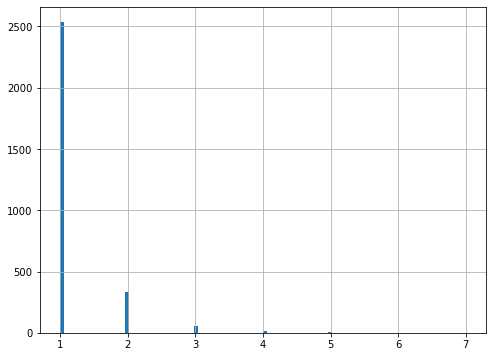

In [37]:
#The vast majority of the goods have only earned one
#rating, and the distribution is heavily weighted to the right.
plt.figure(figsize=(8,6))
#plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=100)

<AxesSubplot:>

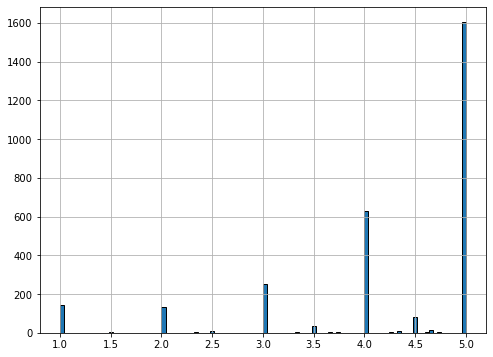

In [38]:
#The ratings have a distribution that is tilted to the left, as seen by us.
#Clusters may be found at each of the points 1,2,3,4,5 
#since this is where the majority of the means are located.
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=100)

<Figure size 576x432 with 0 Axes>

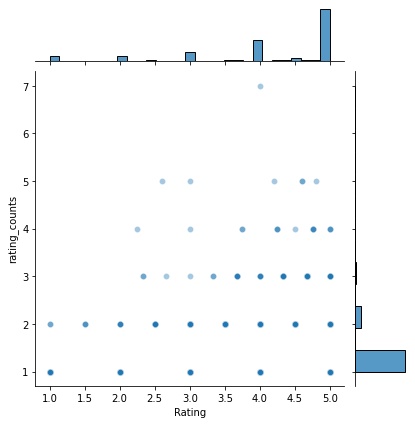

In [39]:
#According to the joint plot shown below, 
#it appears that popular products with higher ratings tend to be rated more frequently. 
#To make people more engaged (bottom of the chart),
#we can start by recommending them based on popularity based system and then 
#gradually graduate them to collaborative system once we have sufficient
#number of data points to giver personlized recommendation.
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

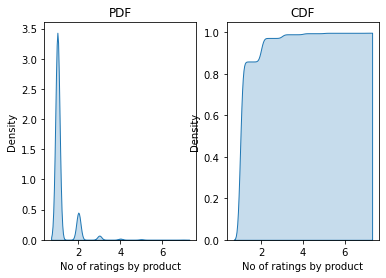

In [40]:
#The number of ratings for each product, denoted by PDF and CDF
#The bulk of the goods in the PDF have extremely few ratings, hence the distribution is skewed.

ax1 = plt.subplot(121)
sns.kdeplot(no_of_ratings_per_product, shade=True, ax=ax1)
plt.xlabel('No of ratings by product')
plt.title("PDF")
ax2 = plt.subplot(122)
sns.kdeplot(no_of_ratings_per_product, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by product')
plt.title('CDF')
plt.show()

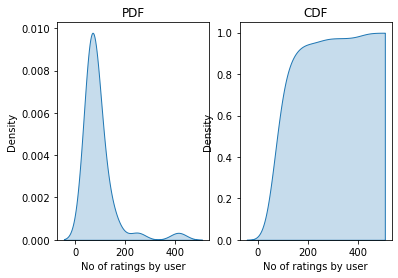

In [41]:
#The number of ratings for each product, denoted by PDF and CDF
#The bulk of the goods in the PDF have extremely few ratings, hence the distribution is skewed.

no_of_ratings_per_user = new_df.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
ax1 = plt.subplot(121)
sns.kdeplot(no_of_ratings_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_ratings_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

<AxesSubplot:xlabel='productId'>

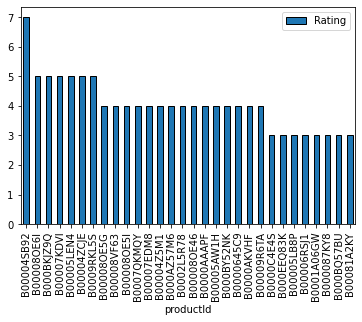

In [42]:
#The product list of the top 30 most popular items 
#is displayed in the bar graph that can be seen below.
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

In [43]:
#Split the data into 80% train and 20% test
train_data, test_data = train_test_split(new_df, test_size = 0.20, random_state=0)
print(train_data.head(5))

                userId   productId  Rating
112409  A38QEATH3NODFM  B00005O7MO       5
427476  A2R6RA8FRBS608  B0002344GQ       4
20814   A11D1KHM7DVOQK  B00001P3XM       4
757131    A6FIAB28IS79  B000BKJZ9Q       5
12623   A3NCIN6TNL0MGA  B00000J4C9       3


In [44]:
#Count of user_ids for each one of a kind product used to calculate the recommendation score
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head()

,productId,score
0,1400532655,1
1,998376234X,1
2,B000001OL6,1
3,B000001OMI,1
4,B000001OMN,1


In [45]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1])     
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,Rank
125,B00004SB92,6,1.0
264,B00004ZCJE,5,2.0
1993,B0009RKL5S,5,3.0
246,B00004Z5M1,4,4.0
547,B0000645C9,4,5.0


In [46]:
# To create predictions for a user, utilise a recommender model that is based on popularity 
# As we have mentioned before, this list will be the same for all of the users
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [47]:
#Since this is a popularity-based recommendation approach,
#regardless of the user's selection, the same goods will be presented on this list, 
#which was compiled based on user votes.
find_recom = ['A15BHBF0L0HV1F','A3VVJIZXLL1QFP','AFHY3XJJ6NCAI','A2WPY1SNQPCC00','AJMJREC90WJVP']   
for i in find_recom:
    print("Here is the recommendation for the userId: %s\n" %(i))
    print(recommend(i))    
    print("\n")

Here is the recommendation for the userId: A15BHBF0L0HV1F

              userId   productId  score  Rank
125   A15BHBF0L0HV1F  B00004SB92      6   1.0
264   A15BHBF0L0HV1F  B00004ZCJE      5   2.0
1993  A15BHBF0L0HV1F  B0009RKL5S      5   3.0
246   A15BHBF0L0HV1F  B00004Z5M1      4   4.0
547   A15BHBF0L0HV1F  B0000645C9      4   5.0


Here is the recommendation for the userId: A3VVJIZXLL1QFP

              userId   productId  score  Rank
125   A3VVJIZXLL1QFP  B00004SB92      6   1.0
264   A3VVJIZXLL1QFP  B00004ZCJE      5   2.0
1993  A3VVJIZXLL1QFP  B0009RKL5S      5   3.0
246   A3VVJIZXLL1QFP  B00004Z5M1      4   4.0
547   A3VVJIZXLL1QFP  B0000645C9      4   5.0


Here is the recommendation for the userId: AFHY3XJJ6NCAI

             userId   productId  score  Rank
125   AFHY3XJJ6NCAI  B00004SB92      6   1.0
264   AFHY3XJJ6NCAI  B00004ZCJE      5   2.0
1993  AFHY3XJJ6NCAI  B0009RKL5S      5   3.0
246   AFHY3XJJ6NCAI  B00004Z5M1      4   4.0
547   AFHY3XJJ6NCAI  B0000645C9      4   5.

C:\Users\kashi\AppData\Local\Temp\ipykernel_9440\2639740726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_recommendations['userId'] = user_id
C:\Users\kashi\AppData\Local\Temp\ipykernel_9440\2639740726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_recommendations['userId'] = user_id
C:\Users\kashi\AppData\Local\Temp\ipykernel_9440\2639740726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [48]:
train_data_sort.head()
#print(pred)

,productId,score,Rank
125,B00004SB92,6,1.0
264,B00004ZCJE,5,2.0
1993,B0009RKL5S,5,3.0
246,B00004Z5M1,4,4.0
547,B0000645C9,4,5.0


In [49]:
test_data.head()

,userId,productId,Rating
795917,A203OCQQ12MAVT,B000CBSGYE,5
572323,A1JWSDDIH5Z7DV,B0006PK8IS,5
671613,A149RNR5RH19YY,B0009MFQ1M,4
992833,A12DLJESJKM1OQ,B000HAQ8EK,4
176185,A25HBO5V8S8SEA,B00006B9ZA,5


In [50]:
#Calculating the Root Mean Square Error 
#(RMSE) of the Recommendation System Based on Popularity 
#The Rating that is shown in the Test Data is the Actual Rating (Act_rating).
test_data2 = test_data.copy()
#ratings.drop(['timestamp'], axis=1,inplace=True)
test_data2.drop(['userId'],axis=1,inplace=True)
test_data2.rename(columns = {'Rating':'Act_rating'}, inplace = True)

In [51]:
test_data2.head()

,productId,Act_rating
795917,B000CBSGYE,5
572323,B0006PK8IS,5
671613,B0009MFQ1M,4
992833,B000HAQ8EK,4
176185,B00006B9ZA,5


In [52]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped2 = train_data.groupby('productId').agg({'Rating': 'sum'}).reset_index()
train_data_grouped2.rename(columns = {'Rating': 'Sum_rating'},inplace=True)
train_data_grouped2.head()

,productId,Sum_rating
0,1400532655,1
1,998376234X,1
2,B000001OL6,4
3,B000001OMI,5
4,B000001OMN,2


In [53]:
train_data_inner = pd.merge(train_data_grouped2, train_data_sort)

In [54]:
train_data_inner.head()

,productId,Sum_rating,score,Rank
0,1400532655,1,1,280.0
1,998376234X,1,1,281.0
2,B000001OL6,4,1,282.0
3,B000001OMI,5,1,283.0
4,B000001OMN,2,1,284.0


In [55]:
#Obtain the average rating of the product across users
train_data_inner["Avg_Rating"] = train_data_inner["Sum_rating"]/train_data_inner["score"]

In [56]:
train_data_inner.head()

,productId,Sum_rating,score,Rank,Avg_Rating
0,1400532655,1,1,280.0,1.0
1,998376234X,1,1,281.0,1.0
2,B000001OL6,4,1,282.0,4.0
3,B000001OMI,5,1,283.0,5.0
4,B000001OMN,2,1,284.0,2.0


In [57]:
#Combine the data from the train, 
#which has an average rating, with the data from the test,
#which has an actual rating at the product level
test_data_inner = pd.merge(train_data_inner, test_data2)

In [58]:
test_data_inner.head()

,productId,Sum_rating,score,Rank,Avg_Rating,Act_rating
0,B00000J061,5,1,286.0,5.0,5
1,B00000JF4L,5,1,311.0,5.0,5
2,B000021YUO,5,1,345.0,5.0,5
3,B00003006E,5,1,353.0,5.0,5
4,B000031KIM,5,1,361.0,5.0,5


In [59]:
#Now that the data have been integrated, we get both the actual rating (abbreviated as Act_rating) and the expected rating (abbreviated as Avg_rating).
#At this point, RMSE can be determined.
test_data_inner.head()

,productId,Sum_rating,score,Rank,Avg_Rating,Act_rating
0,B00000J061,5,1,286.0,5.0,5
1,B00000JF4L,5,1,311.0,5.0,5
2,B000021YUO,5,1,345.0,5.0,5
3,B00003006E,5,1,353.0,5.0,5
4,B000031KIM,5,1,361.0,5.0,5


In [60]:
mse = mean_squared_error(test_data_inner["Act_rating"], test_data_inner["Avg_Rating"])
rmse = math.sqrt(mse)
print("RMSE for popularity based recommendation system:", rmse)

RMSE for popularity based recommendation system: 1.3943845520038947


In [61]:
data1.head()

,userId,productId,Rating
0,A2CX7LUOHB2NDG,321732944,5
1,A2NWSAGRHCP8N5,439886341,1
2,A2WNBOD3WNDNKT,439886341,3
3,A1GI0U4ZRJA8WN,439886341,1
4,A1QGNMC6O1VW39,511189877,5


In [62]:
#Upgrading pip as pakage update for turicreate was giving issues
#!pip install --upgrade pip

In [63]:
#pip install -U turicreate

In [64]:
import pandas as pd

train_data2 = pd.DataFrame(train_data)
test_data2 = pd.DataFrame(test_data)

In [65]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Convert user and item IDs to numerical labels
label_encoder = LabelEncoder()
train_data2['user_label'] = label_encoder.fit_transform(train_data2['userId'])
train_data2['item_label'] = label_encoder.fit_transform(train_data2['productId'].astype(str))

# Compute item popularity
item_popularity = train_data2['item_label'].value_counts().reset_index()
item_popularity.columns = ['item_label', 'popularity']

# Sort items by popularity
sorted_items = item_popularity.sort_values(by='popularity', ascending=False)

# Function to recommend popular items
def recommend_popular_items(user_id, top_n=5):
    return sorted_items.head(top_n)['item_label'].tolist()

# Example usage
user_id = 'user1'
recommended_items = recommend_popular_items(user_id, top_n=5)

In [66]:
# Retrieve the original item IDs
recommended_items_ids = label_encoder.inverse_transform(recommended_items)

# Print the recommended item IDs
print("Recommended items for user", user_id)
print(recommended_items_ids) 

Recommended items for user user1
['B00004SB92' 'B0009RKL5S' 'B00004ZCJE' 'B00004Z5M1' 'B00008OE46']


In [67]:
def precision_at_k(recommended_items, relevant_items, k):
    # Take the top-K recommended items
    recommended_items = recommended_items[:k]
    # Calculate the number of recommended items that are relevant
    num_relevant_items = len(set(recommended_items).intersection(set(relevant_items)))
    # Calculate precision@K
    precision = num_relevant_items / k
    return precision

# Example usage
k = 5  # Top-K recommendations to consider

# Sample recommended items for a user
recommended_items = [1, 3, 5, 7, 9]

# Sample relevant items from the test set
relevant_items = [1, 2, 3, 4, 5]

# Calculate Precision at K
precision = precision_at_k(recommended_items, relevant_items, k)

print("Precision at", k, ":", precision)

Precision at 5 : 0.6


In [68]:
def precision_at_k(recommended_items, relevant_items, k):
    # Take the top-K recommended items
    recommended_items = recommended_items[:k]
    # Calculate the number of recommended items that are relevant
    num_relevant_items = len(set(recommended_items).intersection(set(relevant_items)))
    # Calculate precision@K
    precision = num_relevant_items / k
    return precision

# Example usage
k = 10  # Increase the value of k for more recommendations

# Sample recommended items for a user
recommended_items = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

# Sample relevant items from the test set
relevant_items = [1, 2, 3, 4, 5]

# Calculate Precision at K
precision = precision_at_k(recommended_items, relevant_items, k)

print("Precision at", k, ":", precision)

Precision at 10 : 0.3


In [69]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Example usage
predicted_ratings = popularity_model.predict(test_data2)  # Predicted ratings from the popularity model
actual_ratings = test_data2['Rating']  # Actual ratings from the test dataset

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))

print("RMSE:", rmse)

NameError: name 'popularity_model' is not defined